# ***Sandeep Pandit (TAS366)***

# ***Customer Purchasing Behavior Analysis Using Spark***

In [350]:
!pip install pyspark matplotlib seaborn pandas

In [351]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, desc, to_date, avg, when, month, year, hour
from pyspark.sql.types import StringType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [352]:
spark = SparkSession.builder.appName("CustomerPurchasingAnalysis").getOrCreate()

In [353]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

data = [("7/29/10 18:49",), ("12/5/15 08:30",), ("3/15/20 14:15",)]
columns = ["timestamp_col"]

In [354]:
# Load datasets
file1_path = "/content/file1.csv"  # Update with actual path
file2_path = "/content/file2.csv"  # Update with actual path

df1 = spark.read.csv(file1_path, header=True, inferSchema=True)
df1.show()
df2 = spark.read.csv(file2_path, header=True, inferSchema=True)
df2.show()

+-------+---------+--------------------+--------+------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity| InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|12/1/09 7:45| 6.95|      13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|12/1/09 7:45| 6.75|      13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|12/1/09 7:45| 6.75|      13085|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|12/1/09 7:45|  2.1|      13085|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|12/1/09 7:45| 1.25|      13085|United Kingdom|
| 489434|    22064|PINK DOUGHNUT TRI...|      24|12/1/09 7:45| 1.65|      13085|United Kingdom|
| 489434|    21871| SAVE THE PLANET MUG|      24|12/1/09 7:45| 1.25|      13085|United Kingdom|
| 489434|    21523|FANCY FONT HOME S...|

In [355]:
df = df1.union(df2)

In [356]:
# Display schema and first few rows
df.printSchema()
df.show(5)

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: integer (nullable = true)
 |-- Country: string (nullable = true)

+-------+---------+--------------------+--------+------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity| InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|12/1/09 7:45| 6.95|      13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|12/1/09 7:45| 6.75|      13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|12/1/09 7:45| 6.75|      13085|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|12/1/09 7:45|  2.1|      13085|United King

In [357]:
# Data Cleaning: Removing negative or zero quantities
df_filtered = df.filter(col("Quantity") > 0)

In [358]:
# Fix column names
df_filtered = df_filtered.withColumnRenamed("Customer ID", "CustomerID")

In [359]:
# Convert CustomerID to StringType"
df_filtered = df_filtered.withColumn("CustomerID", col("CustomerID").cast(StringType()))

In [360]:
# Mapping CustomerID to Total Spend
df_spending = df_filtered.groupBy("CustomerID").agg(
    sum(col("Quantity") * col("Price")).alias("TotalSpend")
)

In [361]:
# Case 1: Excluding NULLs from analysis
df_spending_no_nulls = df_spending.filter(col("CustomerID").isNotNull())


# Case 2: Including "Unknown" instead of NULL
df_filtered = df_filtered.fillna({"CustomerID": "Unknown"})
df_spending_with_unknown = df_spending.fillna({"CustomerID": "Unknown"})

In [387]:
# Identifying top 10 customers by total spending
top_customers_no_nulls = df_spending_no_nulls.orderBy(desc("TotalSpend")).limit(10)
top_customers_no_nulls.show()
top_customers=top_customers_no_nulls
top_customers_with_unknown = df_spending_with_unknown.orderBy(desc("TotalSpend")).limit(10)
top_customers_with_unknown.show()

+----------+------------------+
|CustomerID|        TotalSpend|
+----------+------------------+
|     18102| 608821.6500000001|
|     14646| 528602.5199999989|
|     14156| 313946.3699999996|
|     14911|295972.62999999954|
|     17450|246973.08999999997|
|     13694| 196482.8100000001|
|     17511|175603.54999999984|
|     16446|          168472.5|
|     16684|         147142.77|
|     12415| 144458.3699999998|
+----------+------------------+

+----------+------------------+--------------------+
|CustomerID|        TotalSpend|             Segment|
+----------+------------------+--------------------+
|   Unknown|3070862.8200000157|High Value Customers|
|     18102| 608821.6500000001|High Value Customers|
|     14646| 528602.5199999989|High Value Customers|
|     14156| 313946.3699999996|High Value Customers|
|     14911|295972.62999999954|High Value Customers|
|     17450|246973.08999999997|High Value Customers|
|     13694| 196482.8100000001|High Value Customers|
|     17511|175603.54

In [363]:
# Convert to Pandas for visualization
top_customers_no_nulls_pd = top_customers_no_nulls.toPandas()
top_customers_with_unknown_pd = top_customers_with_unknown.toPandas()

<ipython-input-365-f07a143c930e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="CustomerID", y="TotalSpend", data=top_customers_no_nulls_pd, palette="coolwarm")


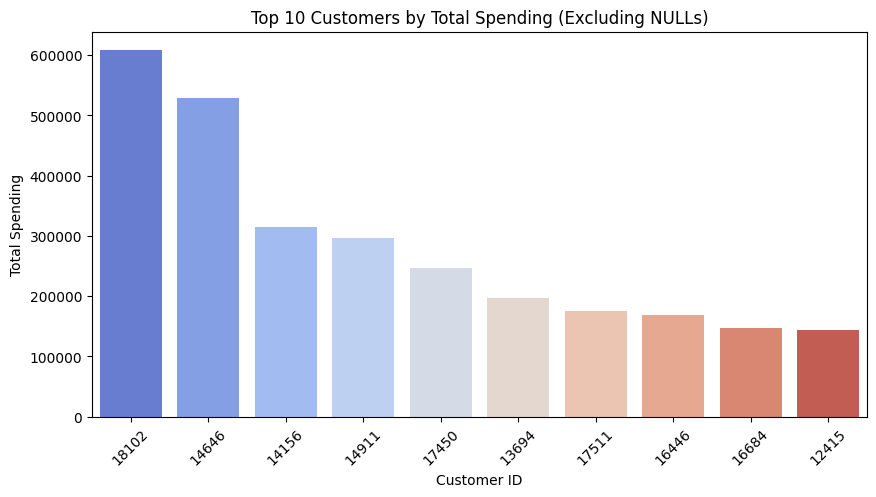

In [365]:
# Visualization: Top 10 Customers (Excluding NULLs)
plt.figure(figsize=(10, 5))
sns.barplot(x="CustomerID", y="TotalSpend", data=top_customers_no_nulls_pd, palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Customer ID")
plt.ylabel("Total Spending")
plt.title("Top 10 Customers by Total Spending (Excluding NULLs)")
plt.show()

<ipython-input-366-f369a3b1ffbd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="CustomerID", y="TotalSpend", data=top_customers_with_unknown_pd, palette="viridis")


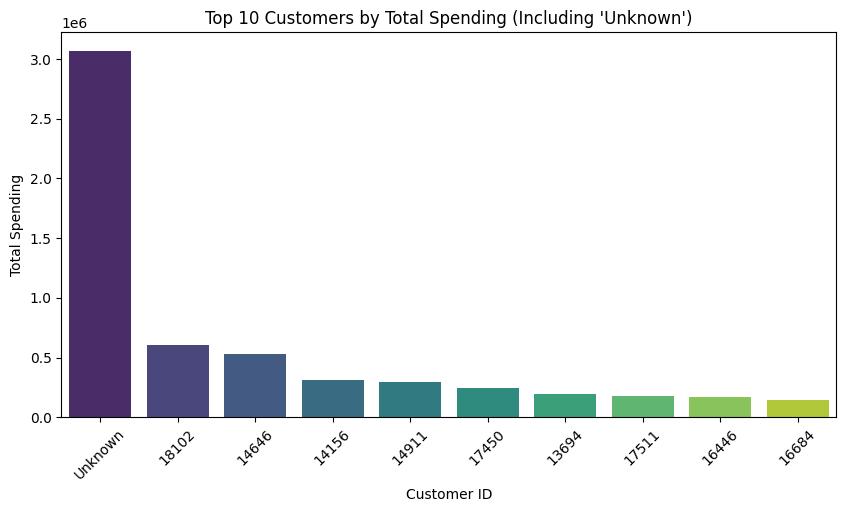

In [366]:
# Visualization: Top 10 Customers (Including 'Unknown' for NULLs)
plt.figure(figsize=(10, 5))
sns.barplot(x="CustomerID", y="TotalSpend", data=top_customers_with_unknown_pd, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Customer ID")
plt.ylabel("Total Spending")
plt.title("Top 10 Customers by Total Spending (Including 'Unknown')")
plt.show()

In [367]:
# Determining the most frequently purchased products
top_products = df_filtered.groupBy("StockCode", "Description").agg(
    count("Quantity").alias("PurchaseCount")
).orderBy(desc("PurchaseCount")).limit(10)

# Convert to Pandas for visualization
top_products_pd = top_products.toPandas()

<ipython-input-368-4808a7e78d5e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="PurchaseCount", y="Description", data=top_products_pd, palette="viridis")


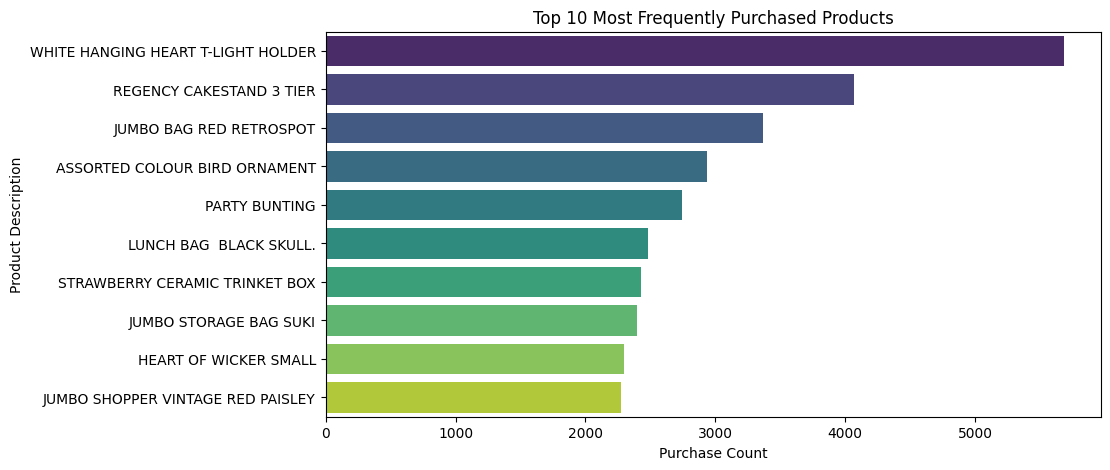

In [368]:
# Visualization: Most Frequently Purchased Products
plt.figure(figsize=(10, 5))
sns.barplot(x="PurchaseCount", y="Description", data=top_products_pd, palette="viridis")
plt.xlabel("Purchase Count")
plt.ylabel("Product Description")
plt.title("Top 10 Most Frequently Purchased Products")
plt.show()

In [369]:
# Analyzing purchasing trends over time
df_filtered = df_filtered.withColumn("InvoiceDate", to_date(col("InvoiceDate"), "MM/dd/yy HH:mm"))

In [370]:
# Extract year and month
df_filtered = df_filtered.withColumn("Year", year(col("InvoiceDate")))
df_filtered = df_filtered.withColumn("Month", month(col("InvoiceDate")))

monthly_trends = df_filtered.groupBy("Year", "Month").agg(
    sum("Quantity").alias("TotalSales")
).orderBy("Year", "Month")
monthly_trends.show()
monthly_trends_pd = monthly_trends.toPandas()

# Create a 'Year-Month' column for better visualization
monthly_trends_pd["Year-Month"] = monthly_trends_pd["Year"].astype(str) + "-" + monthly_trends_pd["Month"].astype(str)

+----+-----+----------+
|Year|Month|TotalSales|
+----+-----+----------+
|2009|   12|    445861|
|2010|    1|    396087|
|2010|    2|    392763|
|2010|    3|    531689|
|2010|    4|    387241|
|2010|    5|    425348|
|2010|    6|    415541|
|2010|    7|    359616|
|2010|    8|    522803|
|2010|    9|    594108|
|2010|   10|    624378|
|2010|   11|    733705|
|2010|   12|    544764|
|2011|    1|    397716|
|2011|    2|    286695|
|2011|    3|    384950|
|2011|    4|    312176|
|2011|    5|    399425|
|2011|    6|    394337|
|2011|    7|    407539|
+----+-----+----------+
only showing top 20 rows



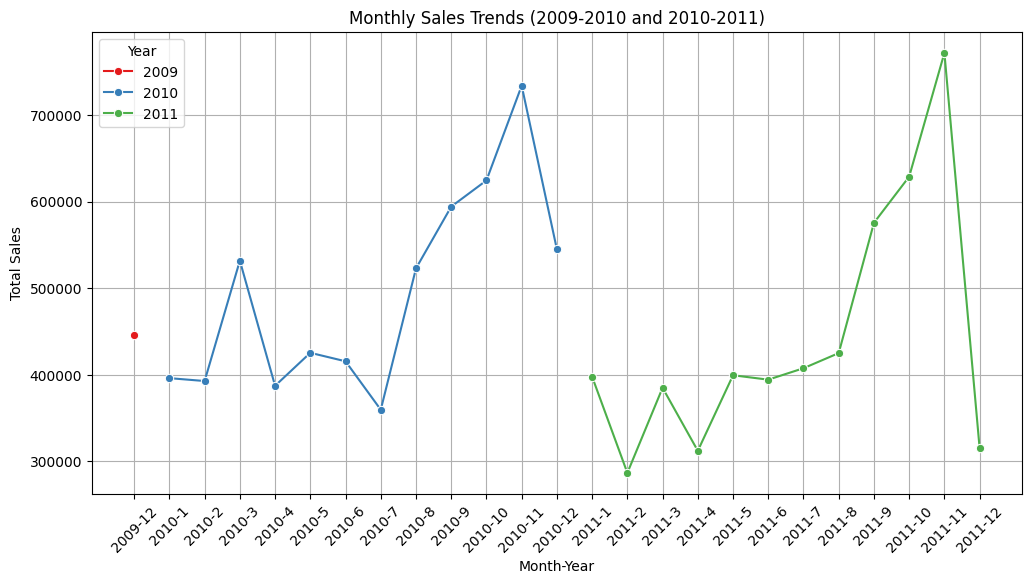

In [371]:

# Visualization: Monthly Sales Trends for Both Years
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trends_pd, x="Year-Month", y="TotalSales", hue="Year", marker="o", palette="Set1")

plt.xticks(rotation=45)
plt.xlabel("Month-Year")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trends (2009-2010 and 2010-2011)")
plt.grid()
plt.legend(title="Year")
plt.show()

In [372]:
# Customer Segmentation based on Spending Behavior
df_spending_with_unknown = df_spending_with_unknown.withColumn(
    "Segment",
    when(col("TotalSpend") > 5000, "High Value Customers")
    .when(col("TotalSpend") > 1000, "Mid Value Customers")
    .otherwise("Low Value Customers")
)

customer_segments_pd = df_spending_with_unknown.groupBy("Segment").count().toPandas()

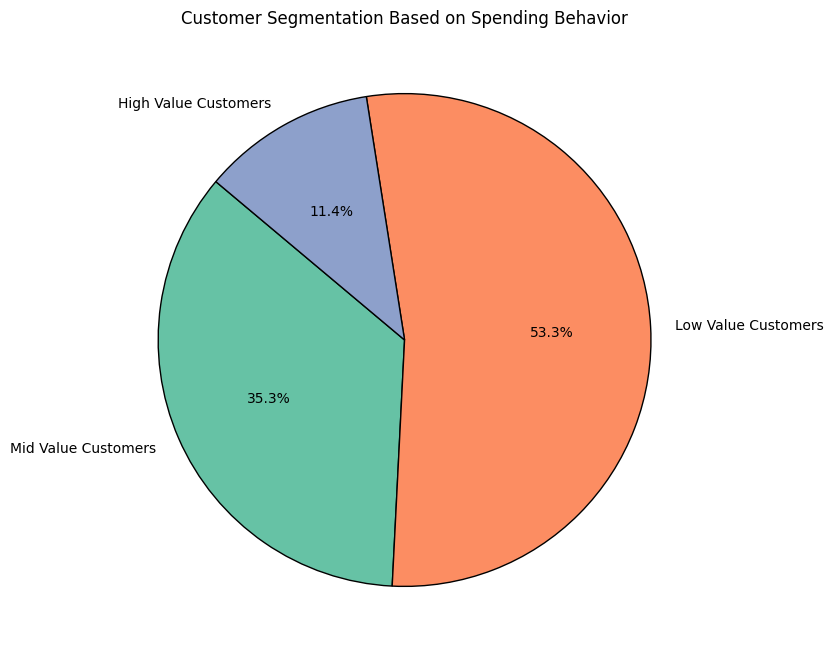

In [373]:
# Visualization: Customer Segmentation
plt.figure(figsize=(8, 8))
plt.pie(
    customer_segments_pd["count"],
    labels=customer_segments_pd["Segment"],
    autopct="%1.1f%%",
    colors=sns.color_palette("Set2"),
    startangle=140,
    wedgeprops={"edgecolor": "black"}
)
plt.title("Customer Segmentation Based on Spending Behavior")
plt.show()

In [374]:
# Customer Retention Analysis
customer_orders = df_filtered.groupBy("CustomerID").agg(count("InvoiceDate").alias("OrderCount"))
repeat_customers = customer_orders.filter(col("OrderCount") > 1).count()
one_time_customers = customer_orders.filter(col("OrderCount") == 1).count()

total_customers = repeat_customers + one_time_customers
retention_rate = repeat_customers / total_customers
print(f"Customer Retention Rate: {retention_rate * 100:.2f}%")




Customer Retention Rate: 98.06%


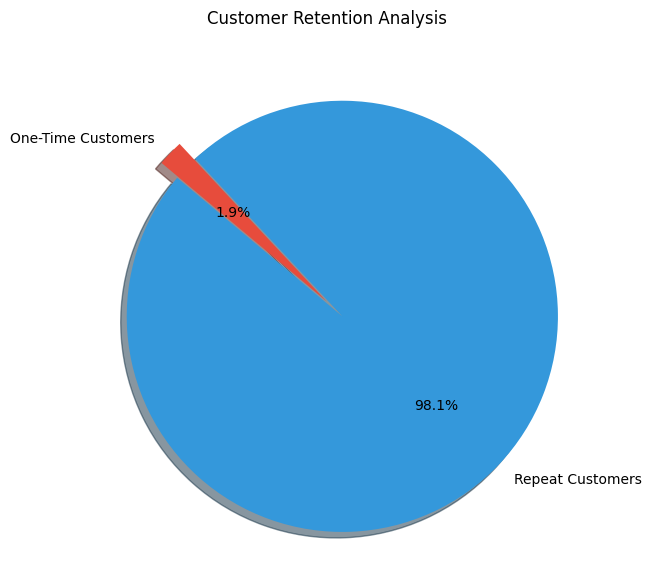

In [375]:
# Plot the Retention Rate
labels = ['Repeat Customers', 'One-Time Customers']
sizes = [repeat_customers, one_time_customers]
colors = ['#3498db', '#e74c3c']
explode = (0.1, 0)  # Explode the first slice for emphasis

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140, shadow=True)
plt.title("Customer Retention Analysis")
plt.show()

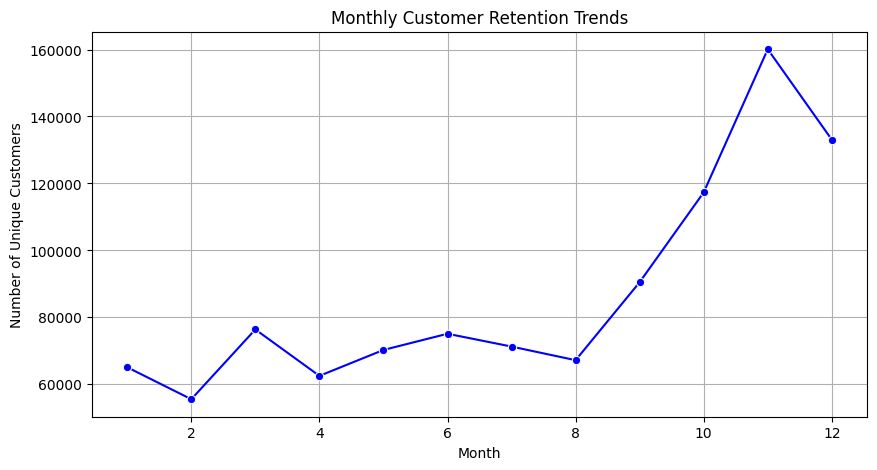

In [376]:
# Extract month from InvoiceDate
df_filtered = df_filtered.withColumn("Month", month(col("InvoiceDate")))

# Count unique customers per month
monthly_customers = df_filtered.groupBy("Month").agg(count("CustomerID").alias("UniqueCustomers")).orderBy("Month")

# Convert to Pandas for visualization
monthly_customers_pd = monthly_customers.toPandas()

# Line chart of monthly customer retention trends
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_customers_pd, x="Month", y="UniqueCustomers", marker="o", color="b")
plt.xlabel("Month")
plt.ylabel("Number of Unique Customers")
plt.title("Monthly Customer Retention Trends")
plt.grid()
plt.show()

In [377]:
# Extract Year from InvoiceDate
df_filtered = df_filtered.withColumn("Year", year(col("InvoiceDate")))

# Filter data for two time periods
df_2009_10 = df_filtered.filter((col("Year") == 2009) | (col("Year") == 2010))
df_2010_11 = df_filtered.filter((col("Year") == 2010) | (col("Year") == 2011))

<ipython-input-378-96d50c701547>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["2009-10", "2010-11"], y=[retention_2009_10, retention_2010_11], palette="Blues")


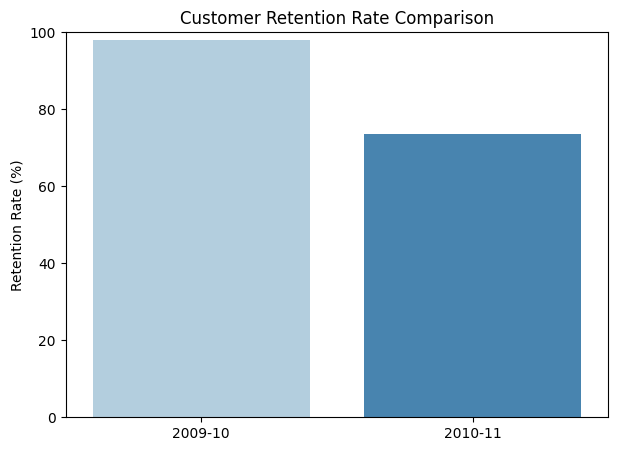

In [378]:
# Count unique customers
customers_2009_10 = df_2009_10.select("CustomerID").distinct().count()
customers_2010_11 = df_2010_11.select("CustomerID").distinct().count()

# Find retained customers (customers in both periods)
common_customers = df_2009_10.select("CustomerID").distinct().intersect(
    df_2010_11.select("CustomerID").distinct()
).count()

# Retention rate calculation
retention_2009_10 = common_customers / customers_2009_10 * 100
retention_2010_11 = common_customers / customers_2010_11 * 100

# Plotting retention rate
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.barplot(x=["2009-10", "2010-11"], y=[retention_2009_10, retention_2010_11], palette="Blues")
plt.ylabel("Retention Rate (%)")
plt.title("Customer Retention Rate Comparison")
plt.ylim(0, 100)
plt.show()

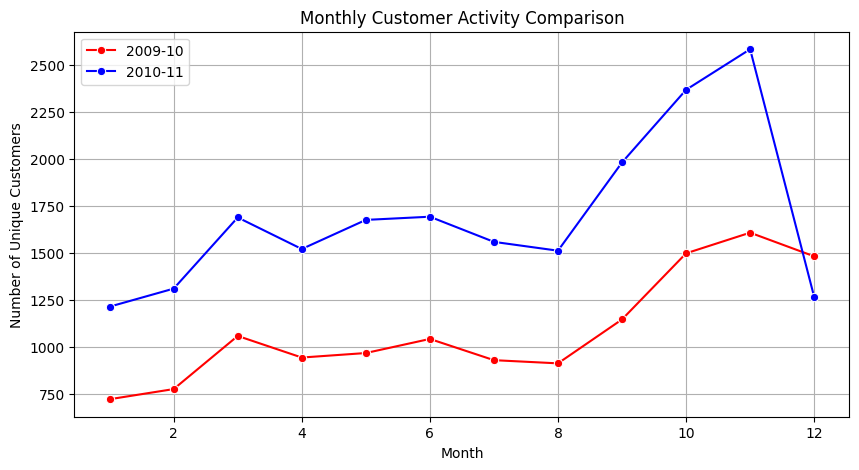

In [379]:
from pyspark.sql.functions import countDistinct, col, month

# Get monthly unique customers for each period
df_2009_10 = df_2009_10.withColumn("Month", month(col("InvoiceDate")))
df_2010_11 = df_2010_11.withColumn("Month", month(col("InvoiceDate")))

# Group by Month and count distinct customers
monthly_customers_2009_10 = df_2009_10.groupBy("Month").agg(countDistinct("CustomerID").alias("UniqueCustomers"))
monthly_customers_2010_11 = df_2010_11.groupBy("Month").agg(countDistinct("CustomerID").alias("UniqueCustomers"))

# Convert to Pandas for plotting
monthly_customers_2009_10_pd = monthly_customers_2009_10.toPandas()
monthly_customers_2010_11_pd = monthly_customers_2010_11.toPandas()

# Plot line chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_customers_2009_10_pd, x="Month", y="UniqueCustomers", marker="o", label="2009-10", color="r")
sns.lineplot(data=monthly_customers_2010_11_pd, x="Month", y="UniqueCustomers", marker="o", label="2010-11", color="b")
plt.xlabel("Month")
plt.ylabel("Number of Unique Customers")
plt.title("Monthly Customer Activity Comparison")
plt.legend()
plt.grid()
plt.show()

<ipython-input-380-2aae60ff4b63>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["2009-10", "2010-11"], y=[sales_2009_10, sales_2010_11], palette="Greens")


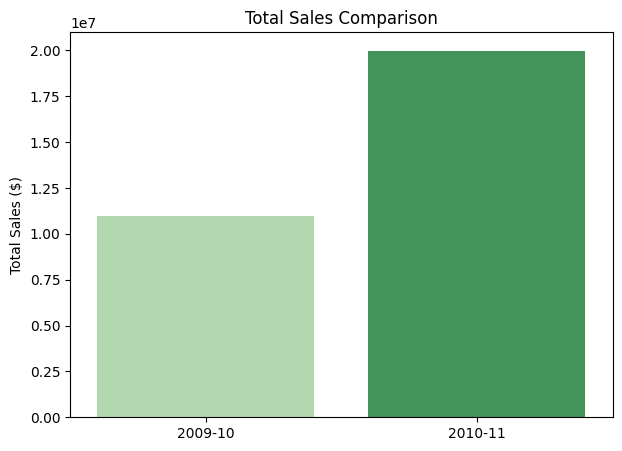

In [380]:
from pyspark.sql.functions import sum

# Calculate total sales for both years
sales_2009_10 = df_2009_10.agg(sum(col("Quantity") * col("Price"))).collect()[0][0]
sales_2010_11 = df_2010_11.agg(sum(col("Quantity") * col("Price"))).collect()[0][0]

# Plot bar chart for total sales comparison
plt.figure(figsize=(7, 5))
sns.barplot(x=["2009-10", "2010-11"], y=[sales_2009_10, sales_2010_11], palette="Greens")
plt.ylabel("Total Sales ($)")
plt.title("Total Sales Comparison")
plt.show()

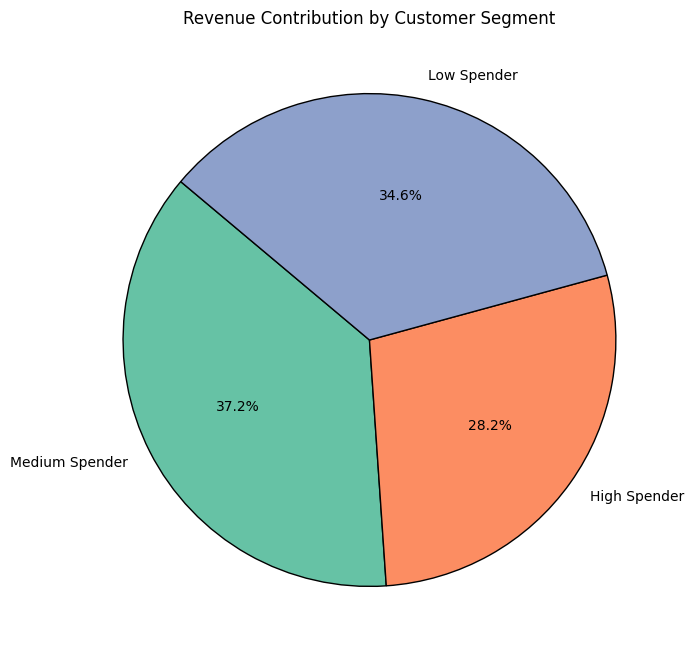

In [381]:
# Aggregate revenue per customer
customer_revenue = df_filtered.groupBy("CustomerID").agg(sum(col("Quantity") * col("Price")).alias("TotalRevenue"))

# Segment customers into groups
customer_revenue = customer_revenue.withColumn(
    "Segment",
    when(col("TotalRevenue") < 500, "Low Spender")
    .when((col("TotalRevenue") >= 500) & (col("TotalRevenue") < 2000), "Medium Spender")
    .otherwise("High Spender")
)

# Count customers in each segment
segment_distribution = customer_revenue.groupBy("Segment").count().toPandas()

# Pie chart visualization
plt.figure(figsize=(8, 8))
plt.pie(
    segment_distribution["count"],
    labels=segment_distribution["Segment"],
    autopct="%1.1f%%",
    colors=sns.color_palette("Set2"),
    startangle=140,
    wedgeprops={"edgecolor": "black"}
)
plt.title("Revenue Contribution by Customer Segment")
plt.show()

In [385]:
import os

output_dirs = {
    "filtered_data": "parquet_outputs/filtered_data",
    "top_customers": "parquet_outputs/top_customers",
    "top_products": "parquet_outputs/top_products",
    "monthly_trends": "parquet_outputs/monthly_trends",
    "customer_segments": "parquet_outputs/customer_segments"
}

# Create directories if they do not exist
for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

In [383]:
!zip -r processed_data.zip processed_data.parquet

  adding: processed_data.parquet/ (stored 0%)
  adding: processed_data.parquet/.part-00002-fa966ebf-ddd9-493e-bc24-d9348e371bb8-c000.snappy.parquet.crc (stored 0%)
  adding: processed_data.parquet/.part-00003-fa966ebf-ddd9-493e-bc24-d9348e371bb8-c000.snappy.parquet.crc (stored 0%)
  adding: processed_data.parquet/.part-00000-fa966ebf-ddd9-493e-bc24-d9348e371bb8-c000.snappy.parquet.crc (stored 0%)
  adding: processed_data.parquet/part-00002-fa966ebf-ddd9-493e-bc24-d9348e371bb8-c000.snappy.parquet (deflated 13%)
  adding: processed_data.parquet/_SUCCESS (stored 0%)
  adding: processed_data.parquet/._SUCCESS.crc (stored 0%)
  adding: processed_data.parquet/.part-00001-fa966ebf-ddd9-493e-bc24-d9348e371bb8-c000.snappy.parquet.crc (stored 0%)
  adding: processed_data.parquet/part-00001-fa966ebf-ddd9-493e-bc24-d9348e371bb8-c000.snappy.parquet (deflated 13%)
  adding: processed_data.parquet/part-00000-fa966ebf-ddd9-493e-bc24-d9348e371bb8-c000.snappy.parquet (deflated 13%)
  adding: processed_d

In [388]:
df_filtered.write.mode("overwrite").parquet(output_dirs["filtered_data"])
top_customers.write.mode("overwrite").parquet(output_dirs["top_customers"])
top_products.write.mode("overwrite").parquet(output_dirs["top_products"])
monthly_trends.write.mode("overwrite").parquet(output_dirs["monthly_trends"])
df_spending.write.mode("overwrite").parquet(output_dirs["customer_segments"])

print("\n✅ Processed data saved in structured Parquet format at 'parquet_outputs/'")


✅ Processed data saved in structured Parquet format at 'parquet_outputs/'


In [389]:
from google.colab import files
import shutil

shutil.make_archive("parquet_outputs", 'zip', "parquet_outputs")
files.download("parquet_outputs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>